# EDA

In [2]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()


In [3]:
# loading merged data
df = pd.read_csv("./data/merged_data.csv")

In [4]:
# for simplicity of plotting, let's create a full title column with max 30 characters for artists and titles
df["full_title"] = (
    df["artist"].apply(lambda x: x[:30] + "..." if len(x) > 30 else x)
    + " - "
    + df["title"].apply(
        lambda x: x[:30] + "..."
        if pd.notna(x) and len(x) > 30
        else x
        if pd.notna(x)
        else ""
    )
)
df.head()

,user_id,song_id,freq,artist,title,full_title
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,Dwight Yoakam,You're The One,Dwight Yoakam - You're The One
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,Barry Tuckwell/Academy of St M... - Horn Conce...
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1,Cartola,Tive Sim,Cartola - Tive Sim
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1,Lonnie Gordon,Catch You Baby (Steve Pitron & Max Sanna Radio...,Lonnie Gordon - Catch You Baby (Steve Pitron &...
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1,Miguel Calo,El Cuatrero,Miguel Calo - El Cuatrero


In [5]:
# number of unique songs we're working with
print(f"Number of unique songs: {df['song_id'].nunique()}")
# number of unique users
print(f"Number of unique users: {df['user_id'].nunique()}")
# total number of interactions
print(f"Total number of interactions: {df.shape[0]}")


Number of unique songs: 163206
Number of unique users: 110000
Total number of interactions: 1450933


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450933 entries, 0 to 1450932
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   user_id     1450933 non-null  object
 1   song_id     1450933 non-null  object
 2   freq        1450933 non-null  int64 
 3   artist      1450933 non-null  object
 4   title       1450932 non-null  object
 5   full_title  1450933 non-null  object
dtypes: int64(1), object(5)
memory usage: 66.4+ MB


In [7]:
# ensuring no duplicate or missing values
print(f"Number of duplicate rows: {df.duplicated().sum()}")
print(f"Number of missing values: {df.isnull().sum().sum()}")


Number of duplicate rows: 0
Number of missing values: 1


In [8]:
# get any row that contains NAN
df[df.isnull().any(axis=1)]

,user_id,song_id,freq,artist,title,full_title
192828,7b3a62a418862aefc4b3d85feb191fa0fd752c69,SOZDBDL12AB018AFFF,1,Sébastien Roch,NaN,Sébastien Roch -


Since we only miss a title, this is not gonna impact our analysis.

<Axes: ylabel='freq'>

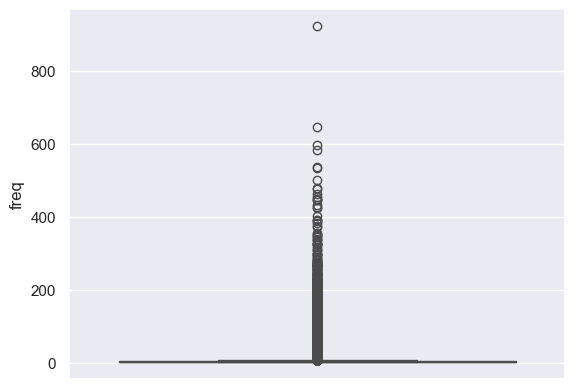

In [9]:
# let's check the distribution of the freq metric
sns.boxplot(df["freq"])


In [10]:
df.freq.describe()

count    1.450933e+06
mean     3.187149e+00
std      7.051664e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      9.230000e+02
Name: freq, dtype: float64

In [11]:
# extracting quantiles
quantiles = df.freq.quantile([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
quantiles


0.01     1.0
0.05     1.0
0.10     1.0
0.25     1.0
0.50     1.0
0.75     3.0
0.90     6.0
0.95    11.0
0.99    28.0
Name: freq, dtype: float64

We can already see that the data is extrenly right skewed. Some users listen to the same song hundreds of times. They're definitely not representative of the general population, and could affect the performance of our models later. As the mean is 3.1, and the 90 quantile is at 6, we can clip the data at 6

<Axes: xlabel='freq', ylabel='Count'>

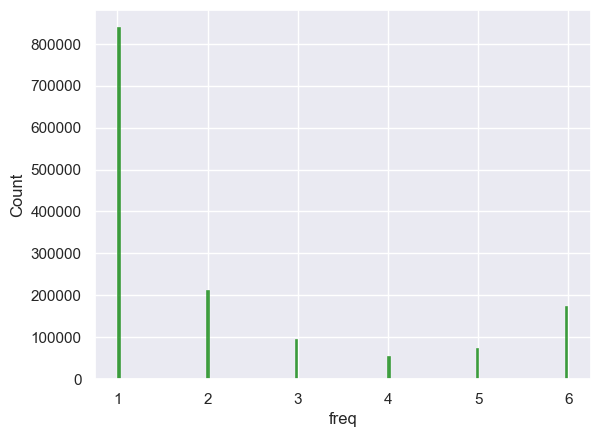

In [12]:
# clipping the data at 6
# checking the distribution
sns.histplot(df.assign(freq=df.freq.clip(upper=6))["freq"], color="green")


We see that most people listen to the same song between 1 and 3 times

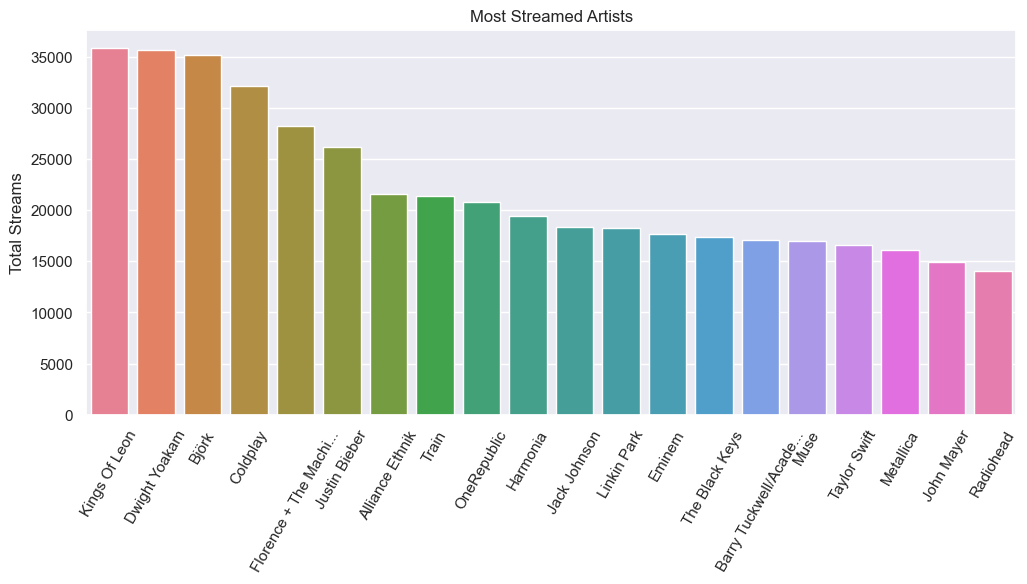

In [13]:
# let's aggregate the data by artist and check artist popularity in terms of total streams
artist_streams = (
    df.groupby("artist")["freq"]
    .sum()
    .sort_values(ascending=False)
    .rename("Total Streams")
    .to_frame()
    .reset_index()
)
artist_streams["artist"] = artist_streams.artist.apply(
    lambda x: x[:20] + "..." if len(x) > 20 else x
)

# plotting the top 10 artists
plt.figure(figsize=(12, 5))
sns.barplot(
    data=artist_streams.head(20),
    x="artist",
    y="Total Streams",
    hue="artist",
)
plt.xticks(rotation=60)
plt.title("Most Streamed Artists")
plt.xlabel("");

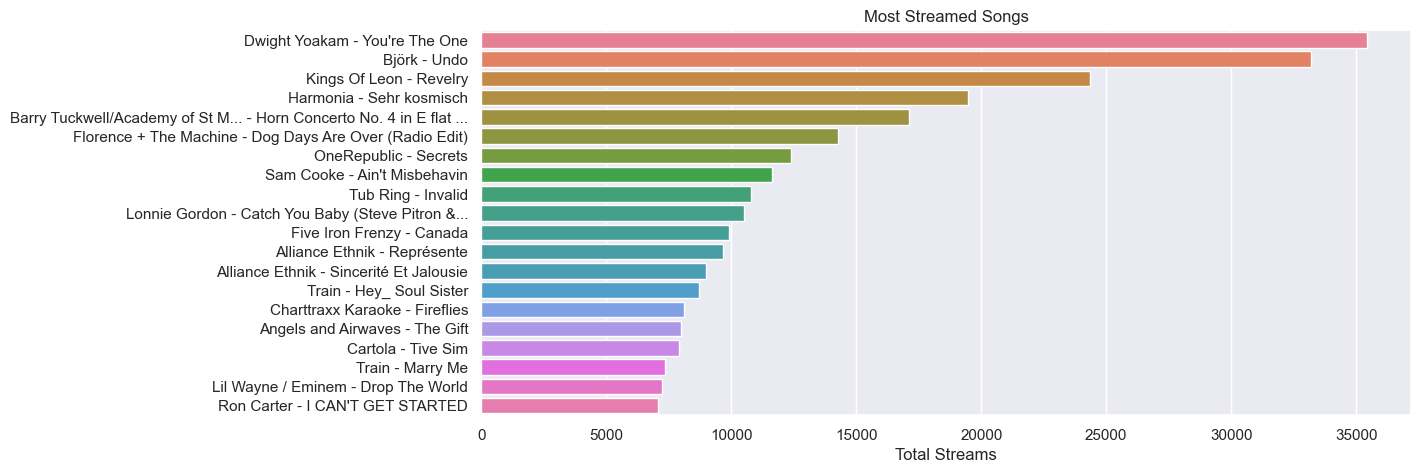

In [14]:
# similarily, let's check the most streamed songs
song_streams = df.groupby(["full_title"])["freq"].sum().reset_index()
song_streams = song_streams.set_index("full_title")["freq"].sort_values(ascending=False)

# plotting the top 20 songs
plt.figure(figsize=(12, 5))
sns.barplot(
    data=song_streams.head(20).rename("Total Streams").to_frame(),
    y="full_title",
    x="Total Streams",
    hue="full_title",
)
plt.title("Most Streamed Songs")
plt.ylabel("");

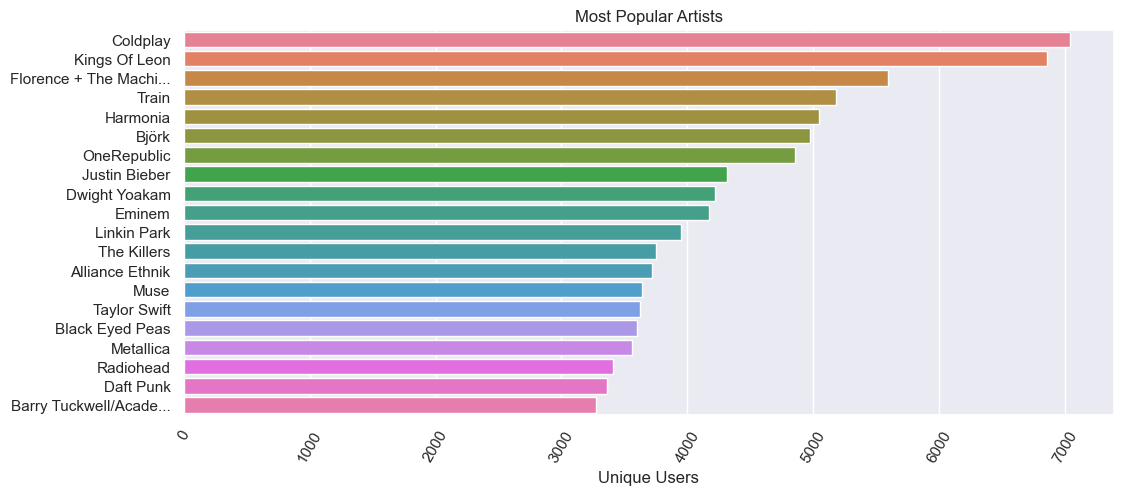

In [15]:
# we can also check the most popular artists by checking the number of unique users that listened to them
artist_popularity = (
    df.groupby("artist")["user_id"]
    .nunique()
    .sort_values(ascending=False)
    .rename("Unique Users")
    .to_frame()
    .reset_index()
)
artist_popularity["artist"] = artist_popularity.artist.apply(
    lambda x: x[:20] + "..." if len(x) > 20 else x
)

# plotting the top 10 artists
plt.figure(figsize=(12, 5))
sns.barplot(
    data=artist_popularity.head(20),
    y="artist",
    x="Unique Users",
    hue="artist",
)
plt.xticks(rotation=60)
plt.title("Most Popular Artists")
plt.ylabel("");

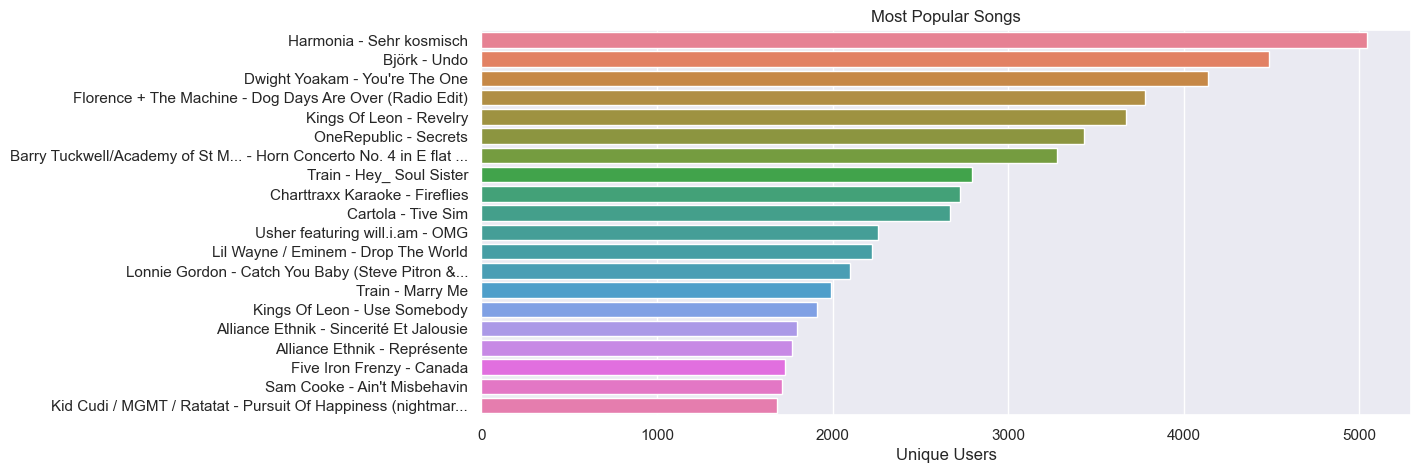

In [16]:
# same for songs
song_popularity = (
    df.groupby(["full_title"])["user_id"]
    .nunique()
    .sort_values(ascending=False)
    .rename("Unique Users")
    .to_frame()
    .reset_index()
)

# plotting the top 20 songs
plt.figure(figsize=(12, 5))
sns.barplot(
    data=song_popularity.head(20),
    y="full_title",
    x="Unique Users",
    hue="full_title",
)
plt.title("Most Popular Songs")
plt.ylabel("");

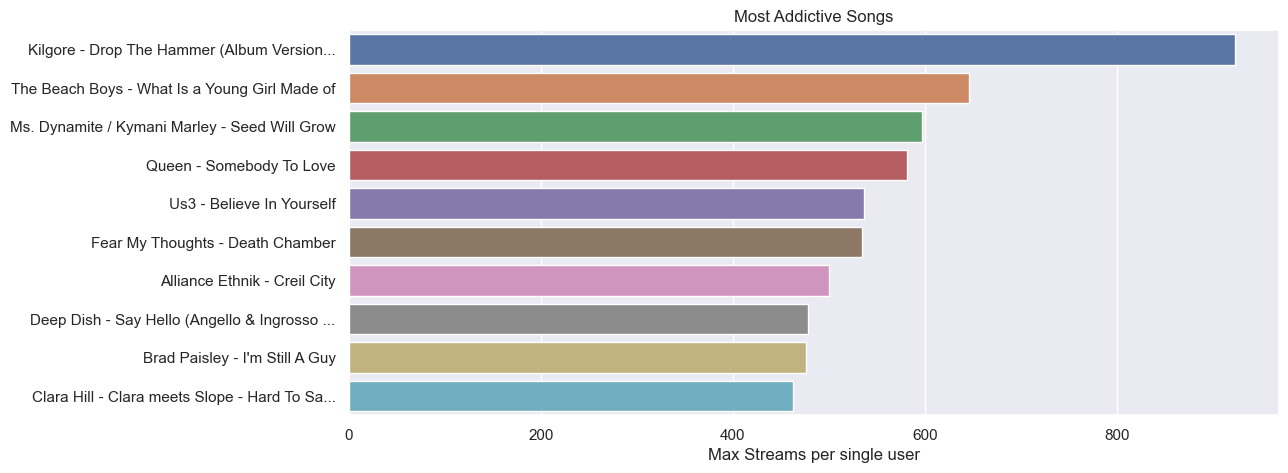

In [17]:
# we can also check the songs that have the most streams per single user, ie the most addictive songs
# extracting the full row for each song with the max freq
max_freq = df.sort_values(by="freq", ascending=False).groupby("full_title").head(1)
max_freq.rename(columns={"freq": "Max Streams per single user"}, inplace=True)

# plotting the top 10 songs
plt.figure(figsize=(12, 5))
sns.barplot(
    data=max_freq.head(10),
    x="Max Streams per single user",
    y="full_title",
    hue="full_title",
)
plt.title("Most Addictive Songs")
plt.xlabel("Max Streams per single user")
plt.ylabel("");

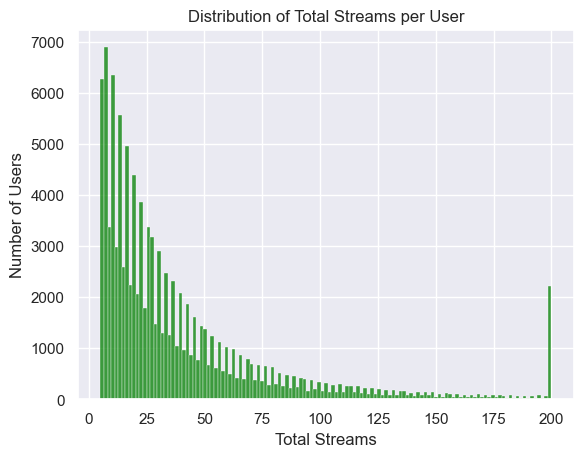

In [18]:
# let's also check the distribution of the total number of streams per user. Users with very litle intteractions will be hard to recommend new songs to
user_streams = (
    df.groupby("user_id")["freq"].sum().rename("Total Streams").to_frame().reset_index()
)

# plotting the distribution
sns.histplot(user_streams["Total Streams"].clip(upper=200), color="green")
plt.title("Distribution of Total Streams per User")
plt.xlabel("Total Streams")
plt.ylabel("Number of Users");

<Axes: ylabel='Total Streams'>

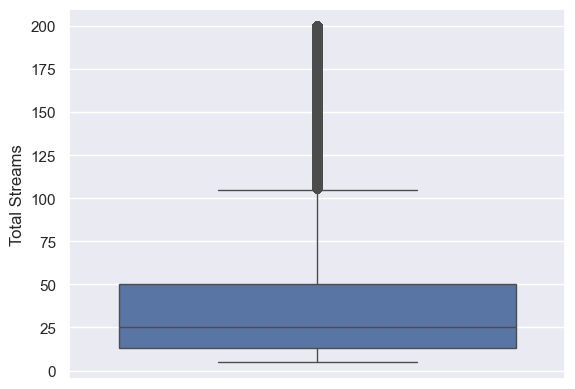

In [19]:
# boxplot
sns.boxplot(user_streams["Total Streams"].clip(upper=200))

In [20]:
user_streams["Total Streams"].describe()

count    110000.000000
mean         42.039455
std          53.315747
min           5.000000
25%          13.000000
50%          25.000000
75%          50.000000
max        1305.000000
Name: Total Streams, dtype: float64

On average, a user generates 42 streams. The median is at 25. The least number of streams a user has is 5

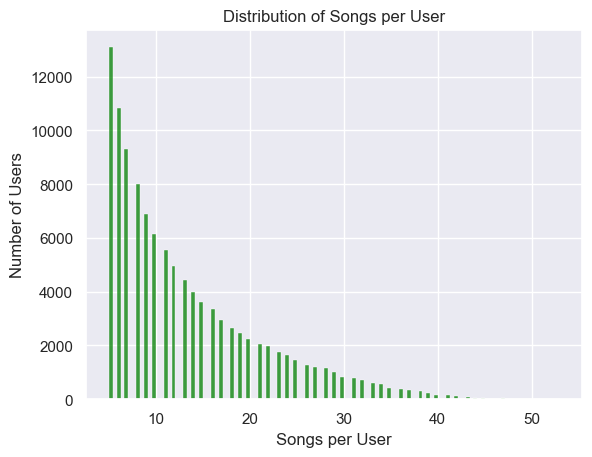

In [21]:
# let's also check how many songs each user has interacted with on average
songs_per_user = (
    df.groupby("user_id")["song_id"]
    .nunique()
    .rename("Songs per User")
    .to_frame()
    .reset_index()
)

# plotting the distribution
sns.histplot(songs_per_user["Songs per User"], color="green")
plt.title("Distribution of Songs per User")
plt.xlabel("Songs per User")
plt.ylabel("Number of Users");

In [22]:
songs_per_user["Songs per User"].describe()

count    110000.000000
mean         13.190300
std           8.070827
min           5.000000
25%           7.000000
50%          11.000000
75%          17.000000
max          53.000000
Name: Songs per User, dtype: float64

Users interact with 13 songs on average, and minimum 5 songs.

In [23]:
# finally, let's categorize the users based on their number of streams
user_streams["user_category"] = pd.cut(
    user_streams["Total Streams"],
    bins=[0, 10, 30, 100, user_streams["Total Streams"].max()],
    labels=["low", "medium", "high", "very high"],
)
user_streams.head()


,user_id,Total Streams,user_category
0,00007a02388c208ea7176479f6ae06f8224355b3,13,medium
1,00014a76ed063e1a749171a253bca9d9a0ff1782,24,medium
2,00015189668691680bb1a2e58afde1541ec92ced,101,very high
3,0001ff7aa2667c8d8b945317b88adaed1c0b9dc2,12,medium
4,00020fcd8b01986a6a85b896ccde6c49f35142ad,44,high


In [24]:
# let's merge the data with the user categories
df = df.merge(user_streams, on="user_id")

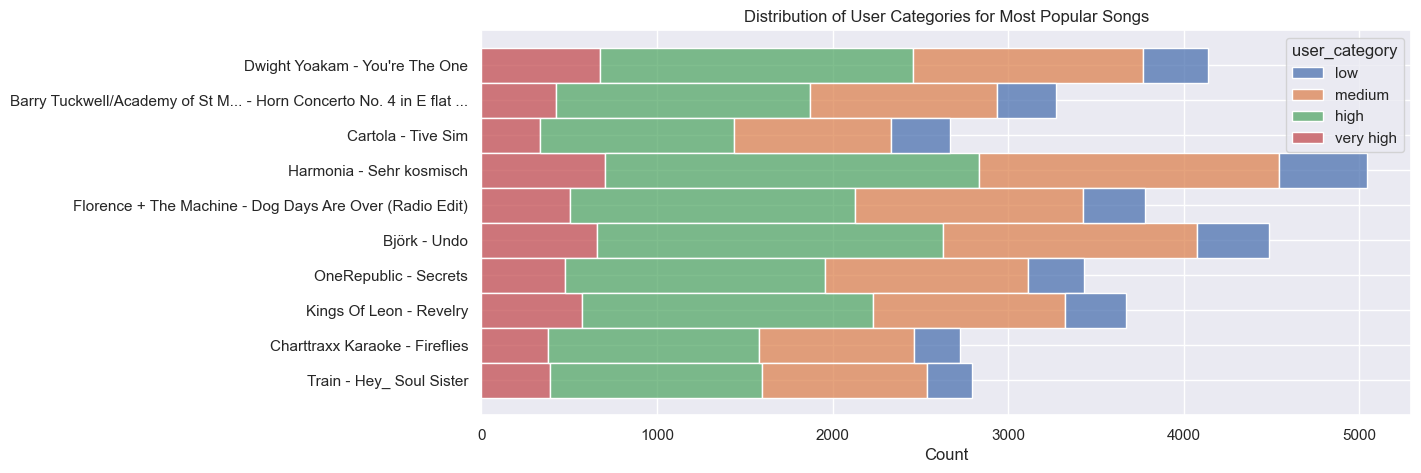

In [25]:
# we can now, for the top 20 songs, check the distribution of users from each category
# let's exctract the popularity of songs based on unique users
popular_songs = df.groupby("song_id")["user_id"].nunique().sort_values(ascending=False)

# let's plot the distribution of user categories for top 10 songs
plt.figure(figsize=(12, 5))
sns.histplot(
    data=df[df.song_id.isin(popular_songs.head(10).index)],
    y="full_title",
    hue="user_category",
    multiple="stack",
)
plt.ylabel("")
plt.title("Distribution of User Categories for Most Popular Songs");

As we see, for the most popular songs, users who listen to a lot of songs are mostly medium and high intensity listeners
